<a href="https://colab.research.google.com/github/spicymaterial/zion-project/blob/master/zion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing necessary libraries.


In [1]:
import tweepy
import json
import textblob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import matplotlib.pyplot as plot
import pandas as pd

OAuth-2 Authorization from twitter

In [2]:
with open('credentials.json', 'r') as f:
    cred = json.load(f)

with open('abbreviations.json', 'r') as f:
    ABBREVIATIONS = json.load(f)
    
consumer_key = cred['api_key']
consumer_secret = cred['api_key_secret']
auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)
api = tweepy.API(auth)

Defining function to fetch tweets(status) from the twitter server

In [3]:
def byUsername():
    user_name = input("Enter Username : ")
    user = api.get_user(user_name)
    timeline = api.user_timeline(user.id, tweet_mode = "extended")
    return timeline

def byQueries():
    query = input("Enter search query : ")
    num = input("Enter number of tweets : ")
    searched_tweets = api.search_tweets(q = query, count = num)
    ids = []
    for tweet in searched_tweets:
        ids.append(tweet.id)
    tweets = []
    for tweet_id in ids:
        tweets.append(api.get_status(tweet_id, tweet_mode = "extended"))
    return tweets

Defining `get_tweet_data` to get necessary attributes from status objefct

In [4]:
def get_tweet_data(tweets):
    header = ['id', 'author', 'full_text', 'retweet_count', 'favorite_count', 'Avg Polarity']
    tweets_data = []
    for tweet in tweets:
        status_dict = vars(tweet)
        tweet_data = {}
        for key in status_dict.keys():
            if key in header:
                if key == 'author':
                    tweet_data[key] = status_dict[key].screen_name
                elif key == 'full_text':
                    text = status_dict[key].replace("\u2019", "'")
                    tweet_data[key] = text
                else:
                    tweet_data[key] = status_dict[key]
        tweets_data.append(tweet_data)
    return tweets_data


Extract hashtags from the tweet

In [5]:
def get_hashtags(tweet):
    text = tweet['full_text']
    pattern = re.compile(r"#(\w+)")
    hashtags = re.findall(pattern, text)
    return hashtags

Getting a polarity of a tweet

In [6]:
def get_polarity(tweet):
    global ABBREVIATIONS
    text = tweet['full_text']
    clean_text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())
    for token in clean_text.split():
        if token.upper() in ABBREVIATIONS.keys():
            clean_text = re.sub(token.upper(), ABBREVIATIONS[token.upper()], clean_text)
    analyser = SentimentIntensityAnalyzer()
    analysis = textblob.TextBlob(clean_text)
    avg_pol = (analysis.sentiment.polarity + analyser.polarity_scores(clean_text)['compound'])/2
    return avg_pol

Display DataFrame

In [7]:
def get_dataframe(data):
    col = ['id', 'author', 'full_text', 'hashtag(s)', 'retweet_count', 'favorite_count', 'Avg Polarity']
    df = pd.DataFrame(data = data, columns = col)
    return df

Plot a graph of Polarity vs Author

In [8]:
def plot_graph(data):
    x_axis = []
    y_axis = []
    for tweet in data:
        x_axis.append(tweet['author'])
        y_axis.append(tweet['Avg Polarity'])
    plot.bar(x_axis, y_axis)
    plot.show()

Getting the user input and showing the graph of polarity vs tweet author from the fetched tweets

1. Get tweet data by username
2. Get tweet data by query
3. Exit


,id,author,full_text,hashtag(s),retweet_count,favorite_count,Avg Polarity
0,1321008360188239872,kalaimannang1,RT @harbhajan_singh: Don't know what else @sur...,[],2703,0,0.000000
1,1321008350562140160,NkNusaik,@Itz_Aruntwitz2 Ipl 2020 இருக்கா,[],0,0,0.000000
2,1321008348032950274,Hippie_Gall,RT @mufaddal_vohra: A senior BCCI source told ...,[],25,0,-0.125000
3,1321008346497912832,IyengarPallavi,"@dna How to play a VICTIM CARD IN CRICKET, Lea...",[],0,0,0.182886
4,1321008312771440640,IndianC48314713,RT @IPL: Here's wishing @SunRisers Captain @da...,[Dream11IPL],383,0,0.854450
5,1321008305498542080,BhavikMhatre1,RT @OAdasule: @Arsh16348411 @ImRo45 @mipaltan ...,[],5,0,-0.436600
6,1321008277065486336,JAISURYAN,RT @sidhuwrites: MS Dhoni will continue to lea...,[],25,0,0.382633
7,1321008250372849669,AKASH3705505707,#staraikelungal who hit the smallest six in t...,[staraikelungal],0,0,0.000000
8,1321008246333841411,ArunanPongo,RT @harbhajan_singh: Don't know what else @sur...,[],2704,0,0.000000
9,1321008238318350337,KrishnaRouth10,RT @harbhajan_singh: Don't know what else @sur...,[],2704,0,0.000000


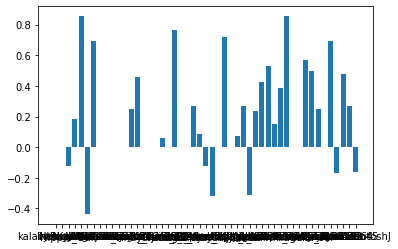

Data added to the file...
_________________________________________________________________

1. Get tweet data by username
2. Get tweet data by query
3. Exit


In [9]:
while True:
    print("1. Get tweet data by username")
    print("2. Get tweet data by query")
    print("3. Exit")
    choice = input("Enter Choice : ")
    if choice != '1' and (choice != '2' and choice != '3'):
        print("Invalid Choice...\n_________________________________________________________________\n")
        continue
    elif choice == '3':
        break
    elif choice == '1':
        data = get_tweet_data(byUsername())
    elif choice == '2':
        data = get_tweet_data(byQueries())

    for tweet in data:
        tweet['Avg Polarity'] = get_polarity(tweet)
        tweet['hashtag(s)'] = get_hashtags(tweet)

    dataframe = get_dataframe(data)
    display(dataframe)

    plot_graph(data)

    choice2 = input("Do you want to save the data(Y/N) : ")
    if choice2.lower() == 'y':
        file_name = input("Enter file name : ")
        dataframe.to_csv(file_name +'.csv')
        with open(file_name + '.json', 'w') as f:
           f.write(json.dumps(data, indent = 4))
        print("Data added to the file...")
    print("_________________________________________________________________\n")
